# IQL Agent Training and Saving Pipeline

This notebook trains Independent Q-Learning (IQL) agents for a variety of simultaneous games.
For each game, it:
1. Initializes the game environment and IQL agents.
2. Trains the agents over a specified number of episodes and iterations.
3. Saves the learned Q-table for each agent.
4. Saves the training data (e.g., average rewards per iteration) for later analysis.

The saved models and data will be stored in the `iql_trainings` directory, organized by game.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time # For potential rendering delays

# Game implementations
from games.rps import RPS
from games.mp import MP
from games.blotto import Blotto
from games.foraging import Foraging

# Agent implementation
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.random_agent import RandomAgent # Added

# Base classes (if needed for type hinting or direct use)
from base.game import SimultaneousGame, AgentID, ActionDict
from base.agent import Agent # Added

## 1. Define Games and Configurations

Specify the games to be tested and their respective configurations.
The `get_game_instance` helper function will be used to create game objects.

In [2]:
games_to_test = [
    {"name": "RPS", "game_class": RPS, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "MP", "game_class": MP, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "Blotto_S10_N5", "game_class": Blotto, "config": {"S": 10, "N": 5}, "train_episodes": 2000, "train_iterations": 1000},
    {"name": "Foraging_5x5_2p_1f", "game_class": Foraging, "config": {"config": "Foraging-5x5-2p-1f-v3", "seed": 42}, "train_episodes": 2000, "train_iterations": 1000}
]

def get_game_instance(game_entry: dict) -> SimultaneousGame:
    """Creates a game instance from a game entry."""
    game_class = game_entry["game_class"]
    config = game_entry["config"]
    if game_entry["name"].startswith("Blotto") or game_entry["name"].startswith("Foraging"):
        return game_class(**config)
    else:
        return game_class()

# Directory to save training outputs
TRAINING_DATA_DIR = "iql_trainings"
if not os.path.exists(TRAINING_DATA_DIR):
    os.makedirs(TRAINING_DATA_DIR)
    print(f"Created directory: {TRAINING_DATA_DIR}")
else:
    print(f"Directory already exists: {TRAINING_DATA_DIR}")

Directory already exists: iql_trainings


## 2. Helper Functions for Agent Creation, Training, and Saving

In [3]:
def create_agents(game: SimultaneousGame, base_config: IQLAgentConfig = None) -> dict[AgentID, IQLAgent]:
    """Creates IQL agents for all agents in the game."""
    if base_config is None:
        # Default configuration if none provided
        base_config = IQLAgentConfig(alpha=0.1, gamma=0.99, epsilon=0.9, min_epsilon=0.01, epsilon_decay=0.999, seed=42)
    
    agents = {}
    for agent_id in game.agents:
        # Potentially customize config per agent or game type if needed here
        agent_config = IQLAgentConfig(
            alpha=base_config.alpha,
            gamma=base_config.gamma,
            epsilon=base_config.epsilon,
            min_epsilon=base_config.min_epsilon,
            epsilon_decay=base_config.epsilon_decay, # Ensure this is slow enough for learning
            max_t=getattr(base_config, 'max_t', 1000), # From IQL.ipynb
            seed=base_config.seed + game.agent_name_mapping[agent_id] if base_config.seed is not None else None, # Vary seed per agent
            optimistic_init=getattr(base_config, 'optimistic_init', 0.1),
            use_reward_shaping=getattr(base_config, 'use_reward_shaping', True)
        )
        agents[agent_id] = IQLAgent(game=game, agent=agent_id, config=agent_config)
    return agents

def create_agents_vs_random(game: SimultaneousGame, iql_agent_id: AgentID, base_config: IQLAgentConfig = None) -> dict[AgentID, Agent]: # Return type changed to Agent
    """Creates one IQL agent and RandomAgents for all other agents in the game."""
    if base_config is None:
        # Default configuration if none provided
        base_config = IQLAgentConfig(alpha=0.1, gamma=0.99, epsilon=0.9, min_epsilon=0.01, epsilon_decay=0.999, seed=42)
    
    agents = {}
    for agent_id in game.agents:
        if agent_id == iql_agent_id:
            # Potentially customize config per agent or game type if needed here
            agent_config = IQLAgentConfig(
                alpha=base_config.alpha,
                gamma=base_config.gamma,
                epsilon=base_config.epsilon,
                min_epsilon=base_config.min_epsilon,
                epsilon_decay=base_config.epsilon_decay, 
                max_t=getattr(base_config, 'max_t', 1000), 
                seed=base_config.seed + game.agent_name_mapping[agent_id] if base_config.seed is not None else None, 
                optimistic_init=getattr(base_config, 'optimistic_init', 0.1),
                use_reward_shaping=getattr(base_config, 'use_reward_shaping', True)
            )
            agents[agent_id] = IQLAgent(game=game, agent=agent_id, config=agent_config)
        else:
            # Create RandomAgent for other agents
            # Ensure seed is different for random agents if desired, or use a fixed one
            random_seed = (base_config.seed + game.agent_name_mapping[agent_id] + 100) if base_config.seed is not None else None
            agents[agent_id] = RandomAgent(game=game, agent=agent_id, seed=random_seed)
    return agents

def play_episode(game: SimultaneousGame, agents: dict[AgentID, Agent], max_steps_per_episode=100, learn_agent_id: AgentID = None, verbose=False, render=False):
    """Plays a single episode of the game with the given agents. Only the agent with learn_agent_id learns."""
    game.reset()
    for agent_id, agent in agents.items():
        agent.reset()
        if isinstance(agent, IQLAgent):
            agent.learn = (agent_id == learn_agent_id) # Only IQL agent with matching ID learns

    cumulative_rewards = {agent_id: 0.0 for agent_id in game.agents}
    is_foraging = isinstance(game, Foraging)
    
    for step in range(max_steps_per_episode):
        if is_foraging and game.env.unwrapped._game_over:
            break
        if not is_foraging and all(game.terminations.values()): # For matrix games
             break

        actions = {agent_id: agents[agent_id].action() for agent_id in game.agents}
        game.step(actions)

        for agent_id in game.agents:
            if isinstance(agents[agent_id], IQLAgent) and agents[agent_id].learn: # Check if it's an IQL agent and should learn
                agents[agent_id].update()
            cumulative_rewards[agent_id] += game.reward(agent_id)

        if verbose:
            print(f"  Step {step}: Actions: {actions}, Rewards: { {a: game.reward(a) for a in game.agents} }")
        
        if render:
            game.render()
            time.sleep(0.1) 
            
        if all(game.terminations.values()) or (is_foraging and game.env.unwrapped._game_over):
            break
            
    return cumulative_rewards

def train_agents_for_game(game: SimultaneousGame, agents: dict[AgentID, IQLAgent], episodes: int, iterations: int, max_steps_per_episode=100):
    """Trains agents for a given game over multiple iterations and episodes."""
    print(f"Starting training for {game.__class__.__name__}...")
    
    all_iterations_average_rewards = {agent_id: [] for agent_id in game.agents}

    for i in range(1, iterations + 1):
        iteration_total_rewards = {agent_id: 0.0 for agent_id in game.agents}
        for ep in range(episodes):
            # Ensure agents are in learning mode
            for agent in agents.values():
                agent.learn = True
            
            episode_rewards = play_episode(game, agents, max_steps_per_episode=max_steps_per_episode, learn_agent_id=None)
            for agent_id in game.agents:
                iteration_total_rewards[agent_id] += episode_rewards[agent_id]
        
        # Calculate average reward for this iteration
        for agent_id in game.agents:
            avg_reward_iteration = iteration_total_rewards[agent_id] / episodes
            all_iterations_average_rewards[agent_id].append(avg_reward_iteration)
            # Epsilon decay is now handled within the agent's update method
            # if agents[agent_id].epsilon > agents[agent_id].min_epsilon:
            #      agents[agent_id].epsilon *= agents[agent_id].epsilon_decay


        if i % (iterations // 10 or 1) == 0: # Print progress roughly 10 times
            print(f"  Iteration {i}/{iterations} completed.")
            for agent_id in game.agents:
                print(f"    Agent {agent_id}: Avg Reward = {all_iterations_average_rewards[agent_id][-1]:.2f}, Epsilon = {agents[agent_id].epsilon:.3f}")
                
    print(f"Training completed for {game.__class__.__name__}.")
    return all_iterations_average_rewards

def train_one_iql_agent_for_game(game: SimultaneousGame, agents: dict[AgentID, Agent], iql_agent_to_train: AgentID, episodes: int, iterations: int, max_steps_per_episode=100):
    """Trains one IQL agent against other (e.g., random) agents."""
    print(f"Starting training for IQL agent {iql_agent_to_train} in {game.__class__.__name__}...")
    
    all_iterations_average_rewards = {agent_id: [] for agent_id in game.agents}
    iql_agent_obj = agents[iql_agent_to_train]

    for i in range(1, iterations + 1):
        iteration_total_rewards = {agent_id: 0.0 for agent_id in game.agents}
        for ep in range(episodes):
            # Ensure only the target IQL agent is in learning mode
            for aid, agent_obj in agents.items():
                if isinstance(agent_obj, IQLAgent):
                    agent_obj.learn = (aid == iql_agent_to_train)
            
            episode_rewards = play_episode(game, agents, max_steps_per_episode=max_steps_per_episode, learn_agent_id=iql_agent_to_train)
            for agent_id in game.agents:
                iteration_total_rewards[agent_id] += episode_rewards[agent_id]
        
        for agent_id in game.agents:
            avg_reward_iteration = iteration_total_rewards[agent_id] / episodes
            all_iterations_average_rewards[agent_id].append(avg_reward_iteration)

        if i % (iterations // 10 or 1) == 0: 
            print(f"  Iteration {i}/{iterations} completed.")
            print(f"    IQL Agent {iql_agent_to_train}: Avg Reward = {all_iterations_average_rewards[iql_agent_to_train][-1]:.2f}, Epsilon = {iql_agent_obj.epsilon:.3f}")
            # Print rewards for other agents too, if desired
            for other_id in game.agents:
                if other_id != iql_agent_to_train:
                    print(f"    Agent {other_id} (Random): Avg Reward = {all_iterations_average_rewards[other_id][-1]:.2f}")
                
    print(f"Training completed for IQL agent {iql_agent_to_train} in {game.__class__.__name__}.")
    return all_iterations_average_rewards

def save_agent_q_table(agent: IQLAgent, game_name: str, agent_id_str: str, base_path: str):
    """Saves the Q-table of an agent to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
    
    file_path = os.path.join(game_specific_path, f"agent_{agent_id_str}_q_table.pkl")
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(agent.Q, f)
        print(f"  Saved Q-table for agent {agent_id_str} to {file_path}")
    except Exception as e:
        print(f"  Error saving Q-table for agent {agent_id_str}: {e}")

def save_training_data(data: dict, game_name: str, base_path: str, filename="training_rewards.pkl"):
    """Saves training data (e.g., rewards) to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
        
    file_path = os.path.join(game_specific_path, filename)
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"  Saved training data for {game_name} to {file_path}")
    except Exception as e:
        print(f"  Error saving training data for {game_name}: {e}")


## 3. Main Training Loop

Iterate through each game, train the agents, and save their Q-tables and the training data.

In [4]:
# Common IQL agent configuration
GAME_MAX_STEPS = {
    "RPS": 1,
    "MP": 1,
    "Blotto_S3_N2": 1, # Example, adjust if you have this specific Blotto config
    "Blotto_S10_N5": 1, # Added for the defined Blotto game
    "Foraging_5x5_2p_1f": 200 
}

# Directory to save training outputs for IQL vs Random
TRAINING_DATA_DIR_VS_RANDOM = "iql_vs_random_trainings"
if not os.path.exists(TRAINING_DATA_DIR_VS_RANDOM):
    os.makedirs(TRAINING_DATA_DIR_VS_RANDOM)
    print(f"Created directory: {TRAINING_DATA_DIR_VS_RANDOM}")
else:
    print(f"Directory already exists: {TRAINING_DATA_DIR_VS_RANDOM}")


for game_entry in games_to_test:
    game_name = game_entry["name"]
    print(f"--- Training IQL vs Random for game: {game_name} ---")

    game_instance = get_game_instance(game_entry)
    
    # Decide which agent will be IQL (e.g., the first one)
    # Game agents are typically named like "agent_0", "agent_1", etc.
    if not game_instance.agents:
        print(f"No agents found for game {game_name}. Skipping.")
        continue
    iql_agent_id_to_train = game_instance.agents[0] # Train the first agent as IQL

    iql_config = IQLAgentConfig(
        alpha=0.1, 
        gamma=0.99, 
        epsilon=0.9, 
        min_epsilon=0.05, 
        epsilon_decay=0.999, # Adjusted for per-step decay in agent
        seed=42 
    )
    
    # Create one IQL agent and others as RandomAgent
    agents = create_agents_vs_random(game_instance, iql_agent_id_to_train, base_config=iql_config)

    episodes_per_iteration = game_entry["train_episodes"]
    num_iterations = game_entry["train_iterations"]
    max_steps = GAME_MAX_STEPS.get(game_name, 100) 

    training_rewards_history = train_one_iql_agent_for_game(
        game_instance, 
        agents, 
        iql_agent_id_to_train,
        episodes=episodes_per_iteration, 
        iterations=num_iterations,
        max_steps_per_episode=max_steps
    )

    # Save Q-table for the IQL agent and training data
    # Ensure the directory includes that this was IQL vs Random
    game_specific_save_name = f"{game_name}_iql_vs_random"
    save_training_data(training_rewards_history, game_specific_save_name, TRAINING_DATA_DIR_VS_RANDOM)
    
    iql_agent_object = agents[iql_agent_id_to_train]
    if isinstance(iql_agent_object, IQLAgent):
        agent_id_simple = str(game_instance.agent_name_mapping[iql_agent_id_to_train])
        save_agent_q_table(iql_agent_object, game_specific_save_name, agent_id_simple, TRAINING_DATA_DIR_VS_RANDOM)
    else:
        print(f"Error: Agent {iql_agent_id_to_train} is not an IQLAgent. Q-table not saved.")
        
    print(f"--- Finished training and saving for {game_specific_save_name} ---")

print("All IQL vs Random training processes completed.")

Directory already exists: iql_vs_random_trainings
--- Training IQL vs Random for game: RPS ---
Starting training for IQL agent agent_0 in RPS...
  Iteration 50/500 completed.
    IQL Agent agent_0: Avg Reward = -0.01, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.01
  Iteration 50/500 completed.
    IQL Agent agent_0: Avg Reward = -0.01, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.01
  Iteration 100/500 completed.
    IQL Agent agent_0: Avg Reward = 0.02, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.02
  Iteration 100/500 completed.
    IQL Agent agent_0: Avg Reward = 0.02, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.02
  Iteration 150/500 completed.
    IQL Agent agent_0: Avg Reward = 0.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.00
  Iteration 150/500 completed.
    IQL Agent agent_0: Avg Reward = 0.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.00
  Iteration 200/500 completed.
    IQL Ag

Directory already exists: iql_vs_random_trainings
--- Training IQL vs Random for game: RPS ---
Starting training for IQL agent agent_0 in RPS...
  Iteration 50/500 completed.
    IQL Agent agent_0: Avg Reward = -0.01, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.01
  Iteration 50/500 completed.
    IQL Agent agent_0: Avg Reward = -0.01, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.01
  Iteration 100/500 completed.
    IQL Agent agent_0: Avg Reward = 0.02, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.02
  Iteration 100/500 completed.
    IQL Agent agent_0: Avg Reward = 0.02, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.02
  Iteration 150/500 completed.
    IQL Agent agent_0: Avg Reward = 0.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.00
  Iteration 150/500 completed.
    IQL Agent agent_0: Avg Reward = 0.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.00
  Iteration 200/500 completed.
    IQL Ag

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Directory already exists: iql_vs_random_trainings
--- Training IQL vs Random for game: RPS ---
Starting training for IQL agent agent_0 in RPS...
  Iteration 50/500 completed.
    IQL Agent agent_0: Avg Reward = -0.01, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.01
  Iteration 50/500 completed.
    IQL Agent agent_0: Avg Reward = -0.01, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.01
  Iteration 100/500 completed.
    IQL Agent agent_0: Avg Reward = 0.02, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.02
  Iteration 100/500 completed.
    IQL Agent agent_0: Avg Reward = 0.02, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.02
  Iteration 150/500 completed.
    IQL Agent agent_0: Avg Reward = 0.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.00
  Iteration 150/500 completed.
    IQL Agent agent_0: Avg Reward = 0.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = -0.00
  Iteration 200/500 completed.
    IQL Ag

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


  Iteration 100/1000 completed.
    IQL Agent agent_0: Avg Reward = 1.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.00
  Iteration 200/1000 completed.
    IQL Agent agent_0: Avg Reward = 1.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.00
  Iteration 200/1000 completed.
    IQL Agent agent_0: Avg Reward = 1.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.00
  Iteration 300/1000 completed.
    IQL Agent agent_0: Avg Reward = 1.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.00
  Iteration 300/1000 completed.
    IQL Agent agent_0: Avg Reward = 1.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.00
  Iteration 400/1000 completed.
    IQL Agent agent_0: Avg Reward = 1.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.00
  Iteration 400/1000 completed.
    IQL Agent agent_0: Avg Reward = 1.00, Epsilon = 0.050
    Agent agent_1 (Random): Avg Reward = 0.00
  Iteration 500/1000 completed.
    IQL Agent ag

## 4. Plotting Training Results (Example)

This section demonstrates how to load and plot the saved training data (average rewards per iteration).


--- Plotting IQL vs Random Training Results ---


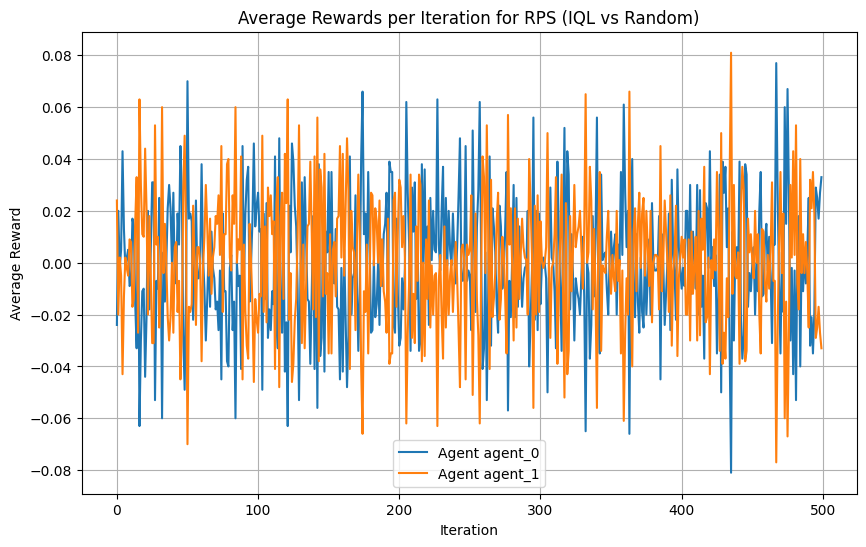


--- Plotting IQL vs Random Training Results ---


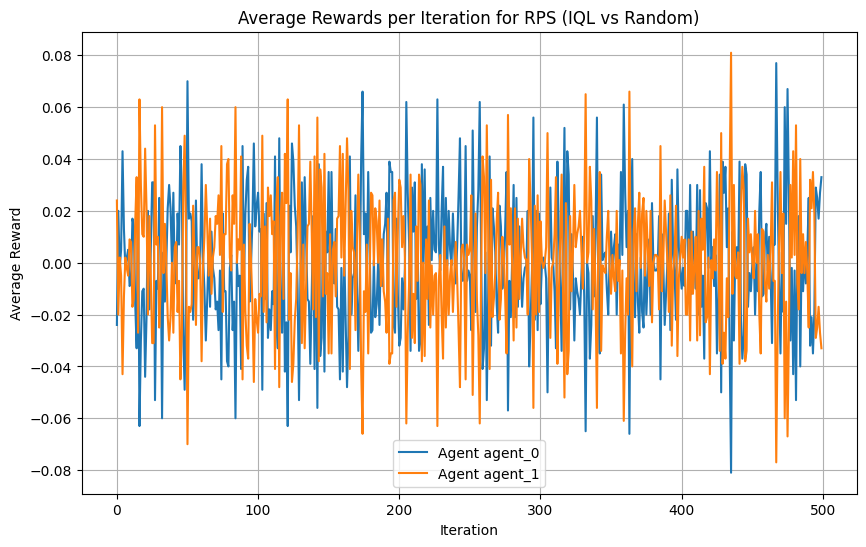

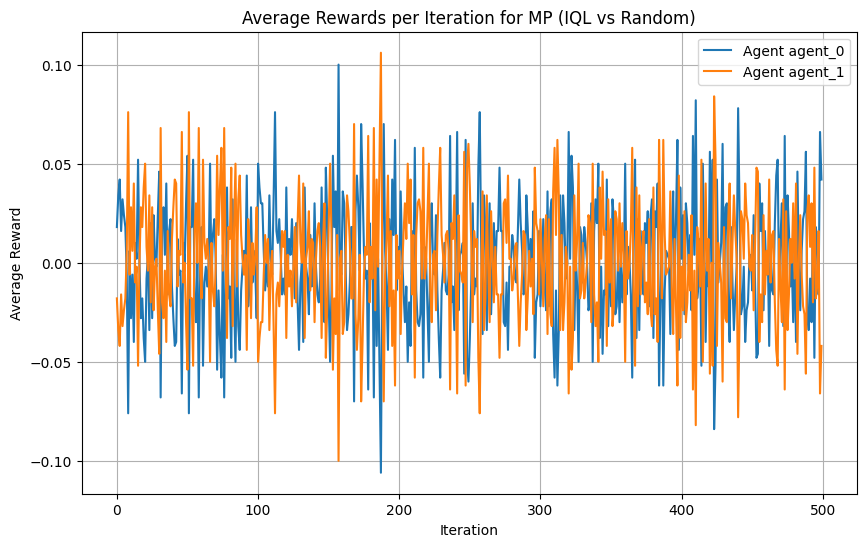


--- Plotting IQL vs Random Training Results ---


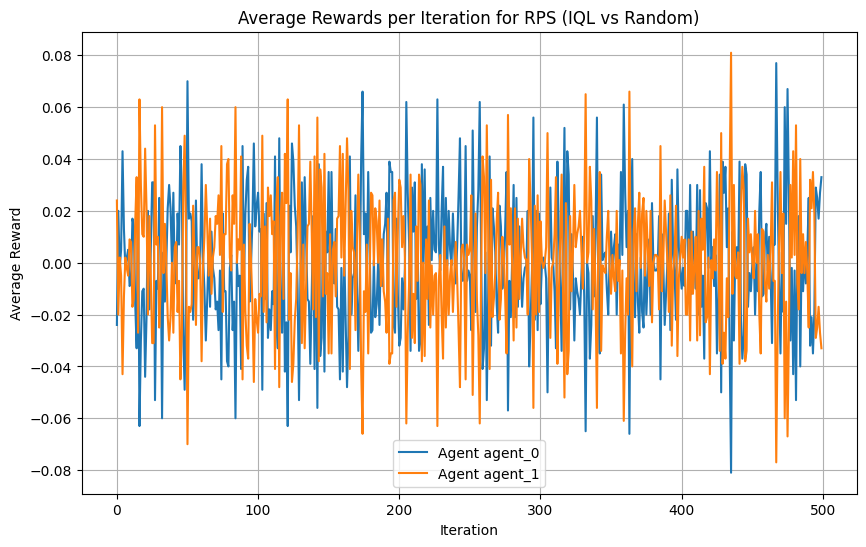

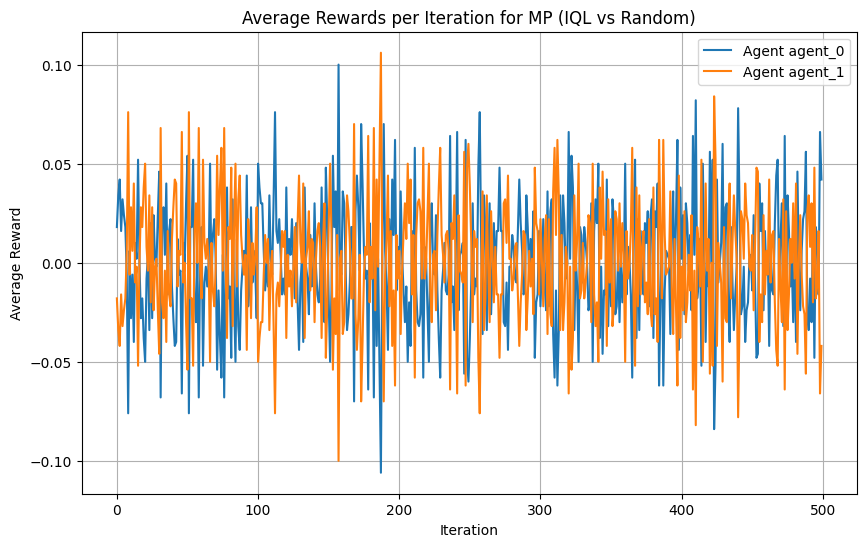

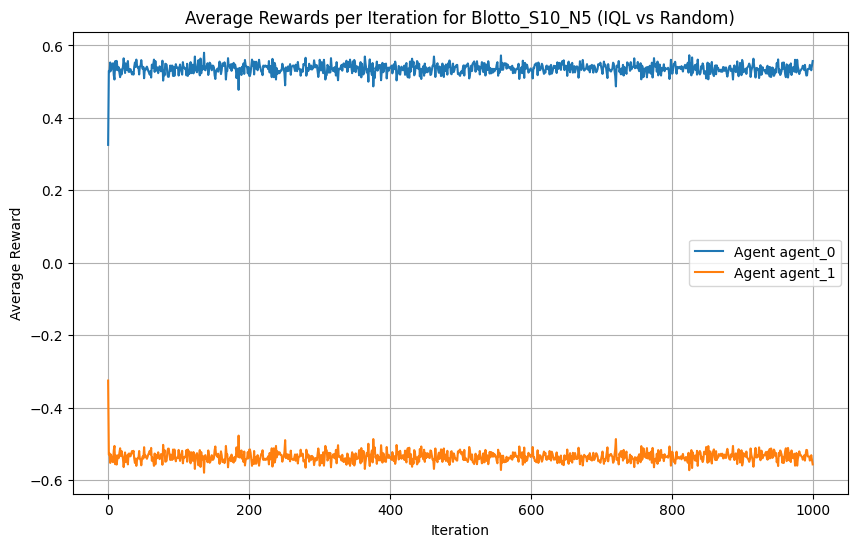


--- Plotting IQL vs Random Training Results ---


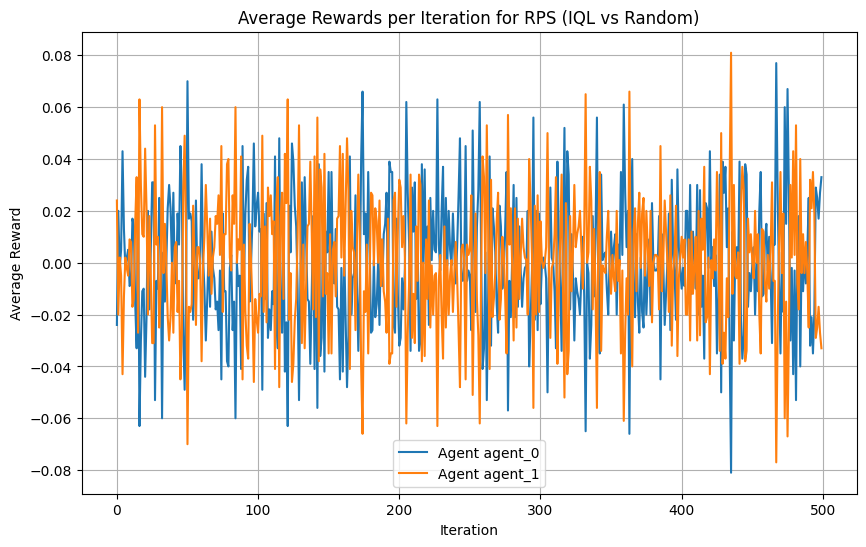

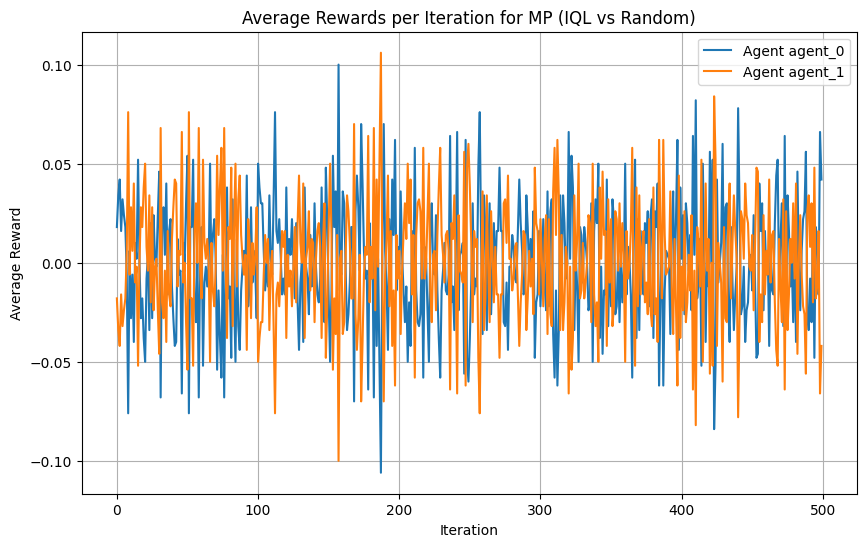

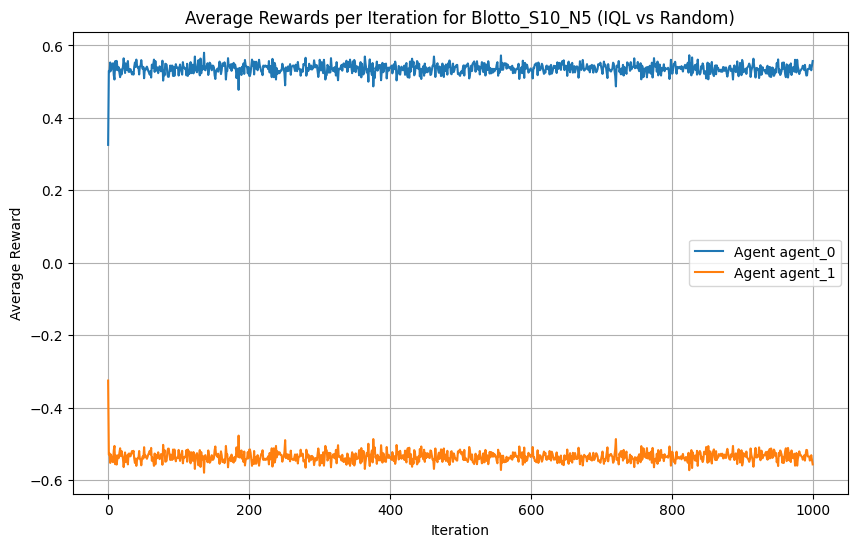

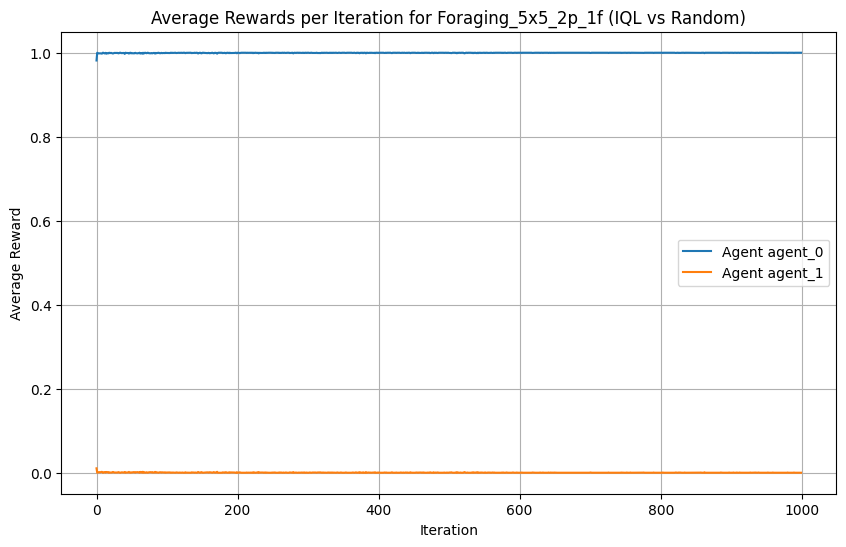

In [5]:
def plot_training_results(game_name, base_path, data_subdir_name=None):
    """Plots training results. data_subdir_name is the specific subdirectory under base_path/game_name."""
    # If data_subdir_name is provided, it implies a structure like base_path/data_subdir_name/training_rewards.pkl
    # Otherwise, it's base_path/game_name/training_rewards.pkl
    if data_subdir_name:
        data_path = os.path.join(base_path, data_subdir_name, "training_rewards.pkl")
    else:
        data_path = os.path.join(base_path, game_name, "training_rewards.pkl")

    if not os.path.exists(data_path):
        print(f"No training data found for {game_name} at {data_path}")
        return

    with open(data_path, 'rb') as f:
        training_rewards = pickle.load(f)

    plt.figure(figsize=(10, 6))
    for agent_id, rewards_list in training_rewards.items():
        plt.plot(rewards_list, label=f"Agent {agent_id}")
    
    plot_title = f"Average Rewards per Iteration for {game_name}"
    if data_subdir_name and game_name in data_subdir_name:
        plot_title = f"Average Rewards per Iteration for {data_subdir_name.replace('_iql_vs_random', '')} (IQL vs Random)"
    elif data_subdir_name:
        plot_title = f"Average Rewards per Iteration for {game_name} ({data_subdir_name})"
        
    plt.title(plot_title)
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot results for the first game trained (IQL vs Random)
if games_to_test:
    print("\n--- Plotting IQL vs Random Training Results ---")
    for game_entry in games_to_test:
        game_name = game_entry["name"]
        # Construct the subdirectory name used during saving
        game_specific_save_name = f"{game_name}_iql_vs_random"
        plot_training_results(game_name, TRAINING_DATA_DIR_VS_RANDOM, data_subdir_name=game_specific_save_name)

# Keep original plotting for comparison if needed, or comment out
# print("\n--- Plotting Original IQL Self-Play Training Results ---")
# if games_to_test:
#     first_game_name = games_to_test[0]["name"]
#     plot_training_results(first_game_name, TRAINING_DATA_DIR)
    
#     second_game_name = games_to_test[1]["name"]
#     plot_training_results(second_game_name, TRAINING_DATA_DIR)

#     third_game_name = games_to_test[2]["name"]
#     plot_training_results(third_game_name, TRAINING_DATA_DIR)

#     fourth_game_name = games_to_test[3]["name"]
#     plot_training_results(fourth_game_name, TRAINING_DATA_DIR)

## 5. Loading Trained Agents (Example for future use)

This section shows a conceptual way to load the Q-tables back into agents.
This would typically be done in a separate notebook for testing or deployment.

In [6]:
def load_agent_q_table(agent: IQLAgent, game_name: str, agent_id_str: str, base_path: str, data_subdir_name: str = None):
    """Loads a Q-table into an agent from a file."""
    # If data_subdir_name is provided, it implies a structure like base_path/data_subdir_name/agent_X_q_table.pkl
    # Otherwise, it's base_path/game_name/agent_X_q_table.pkl
    if data_subdir_name:
        file_path = os.path.join(base_path, data_subdir_name, f"agent_{agent_id_str}_q_table.pkl")
    else:
        file_path = os.path.join(base_path, game_name, f"agent_{agent_id_str}_q_table.pkl")

    if not os.path.exists(file_path):
        print(f"  No Q-table found for agent {agent_id_str} at {file_path}")
        return False
    
    try:
        with open(file_path, 'rb') as f:
            q_table = pickle.load(f)
        agent.Q = q_table
        agent.learn = False 
        agent.epsilon = 0 
        print(f"  Loaded Q-table for agent {agent_id_str} from {file_path}")
        return True
    except Exception as e:
        print(f"  Error loading Q-table for agent {agent_id_str}: {e}")
        return False

# Example of how you might load agents for a specific game (IQL vs Random scenario):
if games_to_test:
    print("\n--- Example: Loading trained IQL agent (vs Random) for RPS ---")
    game_to_load = "RPS"
    game_instance_load_vs_random = get_game_instance([g for g in games_to_test if g["name"] == game_to_load][0])
    
    if game_instance_load_vs_random.agents:
        iql_agent_id_trained = game_instance_load_vs_random.agents[0] # Assuming agent_0 was IQL
        
        # Create agents: one IQL (to load into), others Random
        # Use a config with epsilon=0 for the IQL agent for evaluation
        iql_eval_config = IQLAgentConfig(epsilon=0, seed=420) # Different seed for evaluation setup
        agents_loaded_vs_random = create_agents_vs_random(game_instance_load_vs_random, iql_agent_id_trained, base_config=iql_eval_config)

        iql_agent_to_load = agents_loaded_vs_random[iql_agent_id_trained]
        agent_id_simple_load = str(game_instance_load_vs_random.agent_name_mapping[iql_agent_id_trained])
        
        # Construct the subdirectory name used during saving
        game_specific_load_name = f"{game_to_load}_iql_vs_random"

        if isinstance(iql_agent_to_load, IQLAgent):
            if load_agent_q_table(iql_agent_to_load, game_to_load, agent_id_simple_load, TRAINING_DATA_DIR_VS_RANDOM, data_subdir_name=game_specific_load_name):
                print(f"Successfully loaded IQL agent {iql_agent_id_trained} for {game_to_load} (trained vs Random).")
                print("\n--- Playing one episode with loaded IQL (vs Random) and Random agents for RPS ---")
                rewards = play_episode(game_instance_load_vs_random, agents_loaded_vs_random, 
                                     max_steps_per_episode=GAME_MAX_STEPS.get(game_to_load,1), 
                                     learn_agent_id=None, # No learning during evaluation
                                     verbose=True, render=False)
                print(f"Episode rewards: {rewards}")
            else:
                print(f"Failed to load Q-table for IQL agent {iql_agent_id_trained} for {game_to_load} (trained vs Random).")
        else:
            print(f"Error: Agent {iql_agent_id_trained} is not an IQLAgent in the loaded set.")
    else:
        print(f"Could not run loading example for {game_to_load} as no agents were found.")


--- Example: Loading trained IQL agent (vs Random) for RPS ---
  Loaded Q-table for agent 0 from iql_vs_random_trainings/RPS_iql_vs_random/agent_0_q_table.pkl
Successfully loaded IQL agent agent_0 for RPS (trained vs Random).

--- Playing one episode with loaded IQL (vs Random) and Random agents for RPS ---
  Step 0: Actions: {'agent_0': 0, 'agent_1': 2}, Rewards: {'agent_0': np.float64(1.0), 'agent_1': np.float64(-1.0)}
Episode rewards: {'agent_0': np.float64(1.0), 'agent_1': np.float64(-1.0)}
